In [1]:
import numpy as np
import scipy as sp
import math
import torch
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import optuna
import functools
from sklearn.model_selection import KFold

from typing import Callable
from torch import nn, optim
from data import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

In [2]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

In [3]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"
print(device)


cpu


# Model definition

In [4]:
torch.manual_seed(0) #get the same random numbers everytime you run the code
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

t_span = (0, 10) #wanted timespan
n_step = 100 #number of steps to train the data (number of initial conditions)
n_data = 1000 #number of data per step (per initial condition, this number of datapoints to train, validate, test data)

#validation set will be used to choose hyperparameters, decide when to stop training, compare multiple models fairly and detect overfitting
train, validation, test = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

In [5]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in, hidden_sizes, activation):
        super().__init__()
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }

        #allow for different sizes of neurons for each layer
        layer_sizes = [n_in] + hidden_sizes + [1] #becomes for example [4, 64, 32, 16, 1]
        
        self.net = nn.ModuleList([
            nn.Linear(layer_sizes[i], layer_sizes[i+1])
            for i in range(len(layer_sizes)-1)
        ]) #nn.Linear(4, 64), nn.Linear(64, 32), ..., nn.Linear(16, 1)

        self.activation = act[activation] #chooses a value from the dictionary, e.g. act['tanh']

    def forward(self, x):
        for layer in self.net[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.net[-1](x)

# test model
model = HarmonicModel(
    n_in=4,
    hidden_sizes=[64, 32, 16],   # ← arbitrary shapes
    activation='tanh'
).to(device)

In [6]:
def loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)
    
    return mse_y

In [7]:
#train model
def train_harmonic(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)
    
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        loss = loss_harmonic(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % (int(epochs)) == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return model #return trained model, not final loss

#evaluate model
def evaluate_harmonic(model, data):
    model.eval()
    X_val = data["X"].to(device)
    y_val = data["y_tensor"][:, :, 0].to(device)

    t = X_val[:, :, 3]
    k = X_val[:, :, 0]
    x_00 = X_val[:, :, 1]
    x_01 = X_val[:, :, 2]

    with torch.no_grad():
        y_pred = model(X_val).squeeze(-1)
        loss = loss_harmonic(y_pred, y_val, x_00, x_01, t, k, N_f=1000)

    return loss.item()

# Hyperparameter optimization

## 1) Using random hyperparameter search

In [8]:
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, lr_i: tuple, train_data, val_data, seed=0, device='cpu'):
    torch.manual_seed(seed)
    random.seed(seed)
    result = []

    for _ in tqdm(range(n_trials), desc="Hyperparameter search"):
        n_layers = random.randint(layers_i[0], layers_i[1])  # inclusive

        hidden_sizes = [
            random.randint(neurons_i[0], neurons_i[1])
            for _ in range(n_layers)
        ]

        activation = random.choice(activations_l)

        lr = 10 ** random.uniform(
            torch.log10(torch.tensor(lr_i[0])).item(),
            torch.log10(torch.tensor(lr_i[1])).item()
        )

        params = {
            'hidden_sizes': hidden_sizes,
            'activation': activation,
            'lr': lr
        }

        model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)
        #train_model
        train_harmonic(model, lr=lr, epochs=100, data=train_data)

        #evaluate on validation data
        val_loss = evaluate_harmonic(model,data=val_data)

        result.append((params, val_loss))
    
    return result

In [9]:
n_trials = 50
results_opt_rand = rng_hparameters_search(n_trials,
                                 layers_i=(2, 5),
                                 neurons_i=(16, 128),
                                 activations_l=['tanh', 'sine', 'gelu', 'relu'],
                                 lr_i= (1e-4, 1e-2),
                                 train_data = train,
                                 val_data = validation, 
                                 device=device,
                                 seed=0)

Hyperparameter search:   0%|          | 0/50 [00:00<?, ?it/s]

Hyperparameter search:   2%|▏         | 1/50 [00:17<14:17, 17.50s/it]

Epoch 100/100, Loss: 0.4193


Hyperparameter search:   4%|▍         | 2/50 [00:30<11:47, 14.74s/it]

Epoch 100/100, Loss: 0.6146


Hyperparameter search:   6%|▌         | 3/50 [00:40<10:03, 12.85s/it]

Epoch 100/100, Loss: 0.1388


Hyperparameter search:   8%|▊         | 4/50 [00:49<08:38, 11.28s/it]

Epoch 100/100, Loss: 0.3423


Hyperparameter search:  10%|█         | 5/50 [01:05<09:45, 13.01s/it]

Epoch 100/100, Loss: 0.5449


Hyperparameter search:  12%|█▏        | 6/50 [01:22<10:27, 14.27s/it]

Epoch 100/100, Loss: 0.8022


Hyperparameter search:  14%|█▍        | 7/50 [01:33<09:28, 13.22s/it]

Epoch 100/100, Loss: 0.5403


Hyperparameter search:  16%|█▌        | 8/50 [01:48<09:40, 13.83s/it]

Epoch 100/100, Loss: 0.7056


Hyperparameter search:  18%|█▊        | 9/50 [02:13<11:53, 17.39s/it]

Epoch 100/100, Loss: 0.5895


Hyperparameter search:  20%|██        | 10/50 [02:27<10:45, 16.13s/it]

Epoch 100/100, Loss: 0.7461


Hyperparameter search:  22%|██▏       | 11/50 [02:39<09:47, 15.06s/it]

Epoch 100/100, Loss: 0.1590


Hyperparameter search:  24%|██▍       | 12/50 [02:45<07:45, 12.26s/it]

Epoch 100/100, Loss: 0.1521


Hyperparameter search:  26%|██▌       | 13/50 [02:56<07:20, 11.91s/it]

Epoch 100/100, Loss: 0.5428


Hyperparameter search:  28%|██▊       | 14/50 [03:03<06:11, 10.32s/it]

Epoch 100/100, Loss: 0.7738


Hyperparameter search:  30%|███       | 15/50 [03:13<06:00, 10.29s/it]

Epoch 100/100, Loss: 0.1749


Hyperparameter search:  32%|███▏      | 16/50 [03:19<05:03,  8.94s/it]

Epoch 100/100, Loss: 0.3524


Hyperparameter search:  34%|███▍      | 17/50 [03:40<06:49, 12.42s/it]

Epoch 100/100, Loss: 0.0354


Hyperparameter search:  36%|███▌      | 18/50 [03:53<06:51, 12.85s/it]

Epoch 100/100, Loss: 0.8370


Hyperparameter search:  38%|███▊      | 19/50 [04:01<05:45, 11.13s/it]

Epoch 100/100, Loss: 0.1378


Hyperparameter search:  40%|████      | 20/50 [04:07<04:51,  9.73s/it]

Epoch 100/100, Loss: 0.5790


Hyperparameter search:  42%|████▏     | 21/50 [04:18<04:57, 10.25s/it]

Epoch 100/100, Loss: 0.7464


Hyperparameter search:  44%|████▍     | 22/50 [04:35<05:39, 12.14s/it]

Epoch 100/100, Loss: 0.3026


Hyperparameter search:  46%|████▌     | 23/50 [04:37<04:07,  9.16s/it]

Epoch 100/100, Loss: 0.6155


Hyperparameter search:  48%|████▊     | 24/50 [04:40<03:09,  7.29s/it]

Epoch 100/100, Loss: 0.2756


Hyperparameter search:  50%|█████     | 25/50 [04:44<02:34,  6.16s/it]

Epoch 100/100, Loss: 0.7872


Hyperparameter search:  52%|█████▏    | 26/50 [04:51<02:35,  6.47s/it]

Epoch 100/100, Loss: 0.2517


Hyperparameter search:  54%|█████▍    | 27/50 [04:55<02:11,  5.72s/it]

Epoch 100/100, Loss: 0.6343


Hyperparameter search:  56%|█████▌    | 28/50 [05:03<02:21,  6.42s/it]

Epoch 100/100, Loss: 0.6680


Hyperparameter search:  58%|█████▊    | 29/50 [05:10<02:17,  6.53s/it]

Epoch 100/100, Loss: 0.6330


Hyperparameter search:  60%|██████    | 30/50 [05:29<03:25, 10.26s/it]

Epoch 100/100, Loss: 0.4915


Hyperparameter search:  62%|██████▏   | 31/50 [05:47<03:59, 12.59s/it]

Epoch 100/100, Loss: 0.1686


Hyperparameter search:  64%|██████▍   | 32/50 [05:54<03:19, 11.07s/it]

Epoch 100/100, Loss: 0.2207


Hyperparameter search:  66%|██████▌   | 33/50 [06:03<02:56, 10.37s/it]

Epoch 100/100, Loss: 0.2600


Hyperparameter search:  68%|██████▊   | 34/50 [06:20<03:15, 12.24s/it]

Epoch 100/100, Loss: 0.7736


Hyperparameter search:  70%|███████   | 35/50 [06:27<02:42, 10.80s/it]

Epoch 100/100, Loss: 0.6534


Hyperparameter search:  72%|███████▏  | 36/50 [06:33<02:13,  9.51s/it]

Epoch 100/100, Loss: 0.6686


Hyperparameter search:  74%|███████▍  | 37/50 [06:53<02:42, 12.49s/it]

Epoch 100/100, Loss: 0.2806


Hyperparameter search:  76%|███████▌  | 38/50 [07:21<03:27, 17.28s/it]

Epoch 100/100, Loss: 0.3831


Hyperparameter search:  78%|███████▊  | 39/50 [07:28<02:33, 13.96s/it]

Epoch 100/100, Loss: 0.5180


Hyperparameter search:  80%|████████  | 40/50 [07:47<02:37, 15.72s/it]

Epoch 100/100, Loss: 0.1963


Hyperparameter search:  82%|████████▏ | 41/50 [07:51<01:49, 12.19s/it]

Epoch 100/100, Loss: 0.7696


Hyperparameter search:  84%|████████▍ | 42/50 [08:00<01:30, 11.26s/it]

Epoch 100/100, Loss: 0.4172


Hyperparameter search:  86%|████████▌ | 43/50 [08:16<01:28, 12.65s/it]

Epoch 100/100, Loss: 0.7858


Hyperparameter search:  88%|████████▊ | 44/50 [08:30<01:17, 12.92s/it]

Epoch 100/100, Loss: 0.1378


Hyperparameter search:  90%|█████████ | 45/50 [08:39<00:58, 11.72s/it]

Epoch 100/100, Loss: 0.1076


Hyperparameter search:  92%|█████████▏| 46/50 [08:49<00:44, 11.13s/it]

Epoch 100/100, Loss: 0.7045


Hyperparameter search:  94%|█████████▍| 47/50 [09:01<00:34, 11.48s/it]

Epoch 100/100, Loss: 0.6853


Hyperparameter search:  96%|█████████▌| 48/50 [09:09<00:21, 10.59s/it]

Epoch 100/100, Loss: 0.3896


Hyperparameter search:  98%|█████████▊| 49/50 [09:25<00:12, 12.23s/it]

Epoch 100/100, Loss: 0.7763


Hyperparameter search: 100%|██████████| 50/50 [09:36<00:00, 11.53s/it]

Epoch 100/100, Loss: 0.7759


## 2) Using Bayesian hyperparameter search

In [10]:
# Define your hyperparameter ranges and data
layers_i = (2, 5)
neurons_i = (4, 128)
activations_l = ['tanh', 'sine', 'gelu', 'relu']
lr_i = (1e-4, 1e-2)
train_data = train
val_data   = validation
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def objective(trial, layers_i, neurons_i, activations_l, lr_i, train_data, val_data):
    n_layers = trial.suggest_int("n_layers", layers_i[0], layers_i[1])
    hidden_sizes = [trial.suggest_int(f"neurons_l{i}", neurons_i[0], neurons_i[1]) for i in range(n_layers)]
    activation = trial.suggest_categorical("activation", activations_l)
    lr = trial.suggest_float("lr", lr_i[0], lr_i[1], log=True)


    model = HarmonicModel(n_in=4, hidden_sizes=hidden_sizes, activation=activation).to(device)

    #train model
    train_harmonic(model, lr=lr, epochs=100, data=train_data)

    #evaluate model
    val_loss = evaluate_harmonic(model, data=val_data)

    return val_loss

# Use functools.partial to pass extra arguments
objective_fixed = functools.partial(objective,
                                    layers_i=layers_i,
                                    neurons_i=neurons_i,
                                    activations_l=activations_l,
                                    lr_i=lr_i,
                                    train_data=train_data,
                                    val_data=val_data
                                    )

study = optuna.create_study(direction="minimize")
study.optimize(objective_fixed, n_trials=50)


[I 2025-12-04 14:35:22,194] A new study created in memory with name: no-name-957884d5-e335-4cf2-a090-d704803236b7


[I 2025-12-04 14:35:25,022] Trial 0 finished with value: 0.8887041807174683 and parameters: {'n_layers': 3, 'neurons_l0': 13, 'neurons_l1': 72, 'neurons_l2': 19, 'activation': 'gelu', 'lr': 0.00011282544693144966}. Best is trial 0 with value: 0.8887041807174683.


Epoch 100/100, Loss: 0.8861


[I 2025-12-04 14:35:28,692] Trial 1 finished with value: 0.9120660424232483 and parameters: {'n_layers': 2, 'neurons_l0': 79, 'neurons_l1': 25, 'activation': 'relu', 'lr': 0.00011452579595389484}. Best is trial 0 with value: 0.8887041807174683.


Epoch 100/100, Loss: 0.9095


[I 2025-12-04 14:35:50,430] Trial 2 finished with value: 0.30068621039390564 and parameters: {'n_layers': 5, 'neurons_l0': 112, 'neurons_l1': 5, 'neurons_l2': 116, 'neurons_l3': 83, 'neurons_l4': 44, 'activation': 'sine', 'lr': 0.0029093834874871632}. Best is trial 2 with value: 0.30068621039390564.


Epoch 100/100, Loss: 0.2977


[I 2025-12-04 14:35:56,957] Trial 3 finished with value: 0.11754227429628372 and parameters: {'n_layers': 3, 'neurons_l0': 57, 'neurons_l1': 128, 'neurons_l2': 13, 'activation': 'relu', 'lr': 0.006151289734999877}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.1045


[I 2025-12-04 14:36:18,468] Trial 4 finished with value: 0.6971648335456848 and parameters: {'n_layers': 5, 'neurons_l0': 74, 'neurons_l1': 38, 'neurons_l2': 113, 'neurons_l3': 116, 'neurons_l4': 60, 'activation': 'tanh', 'lr': 0.0002079203108571341}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.6797


[I 2025-12-04 14:36:30,497] Trial 5 finished with value: 0.39718666672706604 and parameters: {'n_layers': 5, 'neurons_l0': 126, 'neurons_l1': 12, 'neurons_l2': 69, 'neurons_l3': 79, 'neurons_l4': 11, 'activation': 'gelu', 'lr': 0.007792294044687842}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.4700


[I 2025-12-04 14:36:48,109] Trial 6 finished with value: 0.7047576904296875 and parameters: {'n_layers': 5, 'neurons_l0': 32, 'neurons_l1': 99, 'neurons_l2': 128, 'neurons_l3': 15, 'neurons_l4': 68, 'activation': 'sine', 'lr': 0.00018994659207737828}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.6944


[I 2025-12-04 14:36:57,584] Trial 7 finished with value: 0.5799816250801086 and parameters: {'n_layers': 5, 'neurons_l0': 65, 'neurons_l1': 42, 'neurons_l2': 55, 'neurons_l3': 45, 'neurons_l4': 70, 'activation': 'gelu', 'lr': 0.00045424365071290945}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.5602


[I 2025-12-04 14:37:08,483] Trial 8 finished with value: 0.7945749163627625 and parameters: {'n_layers': 5, 'neurons_l0': 121, 'neurons_l1': 54, 'neurons_l2': 29, 'neurons_l3': 11, 'neurons_l4': 77, 'activation': 'gelu', 'lr': 0.00021441224864219202}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.7893


[I 2025-12-04 14:37:15,238] Trial 9 finished with value: 0.8797503113746643 and parameters: {'n_layers': 4, 'neurons_l0': 36, 'neurons_l1': 72, 'neurons_l2': 36, 'neurons_l3': 38, 'activation': 'gelu', 'lr': 0.00012853126355740768}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.8777


[I 2025-12-04 14:37:23,715] Trial 10 finished with value: 0.5867121815681458 and parameters: {'n_layers': 2, 'neurons_l0': 47, 'neurons_l1': 124, 'activation': 'relu', 'lr': 0.0015240392866692463}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.5726


[I 2025-12-04 14:37:36,503] Trial 11 finished with value: 0.20947563648223877 and parameters: {'n_layers': 3, 'neurons_l0': 99, 'neurons_l1': 100, 'neurons_l2': 88, 'activation': 'sine', 'lr': 0.004943355283092721}. Best is trial 3 with value: 0.11754227429628372.


Epoch 100/100, Loss: 0.2234


[I 2025-12-04 14:37:50,288] Trial 12 finished with value: 0.0945843756198883 and parameters: {'n_layers': 3, 'neurons_l0': 99, 'neurons_l1': 128, 'neurons_l2': 84, 'activation': 'relu', 'lr': 0.009040010184361555}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.0908


[I 2025-12-04 14:37:59,541] Trial 13 finished with value: 0.2865380644798279 and parameters: {'n_layers': 3, 'neurons_l0': 92, 'neurons_l1': 128, 'neurons_l2': 6, 'activation': 'relu', 'lr': 0.008855960063999907}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.2975


[I 2025-12-04 14:38:13,534] Trial 14 finished with value: 0.10353320091962814 and parameters: {'n_layers': 4, 'neurons_l0': 57, 'neurons_l1': 104, 'neurons_l2': 88, 'neurons_l3': 121, 'activation': 'relu', 'lr': 0.0027502851981141894}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.1259


[I 2025-12-04 14:38:30,324] Trial 15 finished with value: 0.1322820633649826 and parameters: {'n_layers': 4, 'neurons_l0': 90, 'neurons_l1': 102, 'neurons_l2': 88, 'neurons_l3': 128, 'activation': 'relu', 'lr': 0.0022894853337269753}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.1382


[I 2025-12-04 14:38:43,239] Trial 16 finished with value: 0.6558323502540588 and parameters: {'n_layers': 4, 'neurons_l0': 12, 'neurons_l1': 109, 'neurons_l2': 86, 'neurons_l3': 99, 'activation': 'tanh', 'lr': 0.0009366751544681581}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.6334


[I 2025-12-04 14:38:55,756] Trial 17 finished with value: 0.11590073257684708 and parameters: {'n_layers': 4, 'neurons_l0': 107, 'neurons_l1': 85, 'neurons_l2': 66, 'neurons_l3': 56, 'activation': 'relu', 'lr': 0.004131588253476363}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.1214


[I 2025-12-04 14:39:03,434] Trial 18 finished with value: 0.5688104629516602 and parameters: {'n_layers': 2, 'neurons_l0': 82, 'neurons_l1': 114, 'activation': 'relu', 'lr': 0.0008435347003411388}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.5515


[I 2025-12-04 14:39:12,673] Trial 19 finished with value: 0.18435639142990112 and parameters: {'n_layers': 3, 'neurons_l0': 55, 'neurons_l1': 89, 'neurons_l2': 101, 'activation': 'relu', 'lr': 0.0027474351594848224}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.1737


[I 2025-12-04 14:39:23,068] Trial 20 finished with value: 0.5900508761405945 and parameters: {'n_layers': 4, 'neurons_l0': 35, 'neurons_l1': 88, 'neurons_l2': 51, 'neurons_l3': 103, 'activation': 'tanh', 'lr': 0.0016434364908642792}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.5685


[I 2025-12-04 14:39:36,813] Trial 21 finished with value: 0.12984301149845123 and parameters: {'n_layers': 4, 'neurons_l0': 108, 'neurons_l1': 84, 'neurons_l2': 71, 'neurons_l3': 55, 'activation': 'relu', 'lr': 0.004499485292498751}. Best is trial 12 with value: 0.0945843756198883.


Epoch 100/100, Loss: 0.0871


[I 2025-12-04 14:39:56,407] Trial 22 finished with value: 0.08547137677669525 and parameters: {'n_layers': 4, 'neurons_l0': 106, 'neurons_l1': 114, 'neurons_l2': 78, 'neurons_l3': 69, 'activation': 'relu', 'lr': 0.004021458914811424}. Best is trial 22 with value: 0.08547137677669525.


Epoch 100/100, Loss: 0.0913


[I 2025-12-04 14:40:11,978] Trial 23 finished with value: 0.05888192728161812 and parameters: {'n_layers': 4, 'neurons_l0': 95, 'neurons_l1': 119, 'neurons_l2': 79, 'neurons_l3': 77, 'activation': 'relu', 'lr': 0.009690540235738917}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.0583


[I 2025-12-04 14:40:25,270] Trial 24 finished with value: 0.14759965240955353 and parameters: {'n_layers': 3, 'neurons_l0': 95, 'neurons_l1': 118, 'neurons_l2': 77, 'activation': 'relu', 'lr': 0.009649532346430722}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.1340


[I 2025-12-04 14:40:40,796] Trial 25 finished with value: 0.09788650274276733 and parameters: {'n_layers': 4, 'neurons_l0': 117, 'neurons_l1': 116, 'neurons_l2': 100, 'neurons_l3': 74, 'activation': 'relu', 'lr': 0.006091335569881338}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.0948


[I 2025-12-04 14:40:53,509] Trial 26 finished with value: 0.12915876507759094 and parameters: {'n_layers': 3, 'neurons_l0': 102, 'neurons_l1': 118, 'neurons_l2': 57, 'activation': 'relu', 'lr': 0.006808700465883732}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.1158


[I 2025-12-04 14:41:11,550] Trial 27 finished with value: 0.09338420629501343 and parameters: {'n_layers': 4, 'neurons_l0': 84, 'neurons_l1': 110, 'neurons_l2': 100, 'neurons_l3': 92, 'activation': 'relu', 'lr': 0.003924673829664175}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.0933


[I 2025-12-04 14:41:34,120] Trial 28 finished with value: 0.20472073554992676 and parameters: {'n_layers': 4, 'neurons_l0': 85, 'neurons_l1': 95, 'neurons_l2': 108, 'neurons_l3': 92, 'activation': 'sine', 'lr': 0.0036854330329228573}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.2300


[I 2025-12-04 14:41:44,806] Trial 29 finished with value: 0.5682217478752136 and parameters: {'n_layers': 4, 'neurons_l0': 75, 'neurons_l1': 62, 'neurons_l2': 100, 'neurons_l3': 76, 'activation': 'tanh', 'lr': 0.001706418883895485}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.5438


[I 2025-12-04 14:41:53,892] Trial 30 finished with value: 0.10002905130386353 and parameters: {'n_layers': 4, 'neurons_l0': 71, 'neurons_l1': 75, 'neurons_l2': 45, 'neurons_l3': 63, 'activation': 'relu', 'lr': 0.005218189125769778}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.1461


[I 2025-12-04 14:42:06,017] Trial 31 finished with value: 0.08953902870416641 and parameters: {'n_layers': 3, 'neurons_l0': 103, 'neurons_l1': 111, 'neurons_l2': 78, 'activation': 'relu', 'lr': 0.00978229334527127}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.0905


[I 2025-12-04 14:42:17,149] Trial 32 finished with value: 0.18489491939544678 and parameters: {'n_layers': 3, 'neurons_l0': 86, 'neurons_l1': 109, 'neurons_l2': 81, 'activation': 'relu', 'lr': 0.009870455108956469}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.3571


[I 2025-12-04 14:42:31,026] Trial 33 finished with value: 0.2655172348022461 and parameters: {'n_layers': 4, 'neurons_l0': 115, 'neurons_l1': 108, 'neurons_l2': 76, 'neurons_l3': 92, 'activation': 'relu', 'lr': 0.0032861517733833775}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.2814


[I 2025-12-04 14:42:41,084] Trial 34 finished with value: 0.3546336889266968 and parameters: {'n_layers': 2, 'neurons_l0': 128, 'neurons_l1': 94, 'activation': 'relu', 'lr': 0.006707219696128723}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.3576


[I 2025-12-04 14:42:56,658] Trial 35 finished with value: 0.37948641180992126 and parameters: {'n_layers': 3, 'neurons_l0': 106, 'neurons_l1': 120, 'neurons_l2': 96, 'activation': 'relu', 'lr': 0.000679479600208291}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.3722


[I 2025-12-04 14:43:15,730] Trial 36 finished with value: 0.2566782832145691 and parameters: {'n_layers': 5, 'neurons_l0': 94, 'neurons_l1': 112, 'neurons_l2': 61, 'neurons_l3': 67, 'neurons_l4': 127, 'activation': 'relu', 'lr': 0.002286316344540036}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.1534


[I 2025-12-04 14:43:41,163] Trial 37 finished with value: 0.11969289183616638 and parameters: {'n_layers': 4, 'neurons_l0': 80, 'neurons_l1': 79, 'neurons_l2': 125, 'neurons_l3': 107, 'activation': 'sine', 'lr': 0.00543645859478524}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.1238


[I 2025-12-04 14:43:53,203] Trial 38 finished with value: 0.6738691926002502 and parameters: {'n_layers': 3, 'neurons_l0': 5, 'neurons_l1': 122, 'neurons_l2': 112, 'activation': 'tanh', 'lr': 0.0012681436826774625}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.6431


[I 2025-12-04 14:44:11,905] Trial 39 finished with value: 0.14454352855682373 and parameters: {'n_layers': 5, 'neurons_l0': 65, 'neurons_l1': 33, 'neurons_l2': 96, 'neurons_l3': 88, 'neurons_l4': 118, 'activation': 'gelu', 'lr': 0.007339465593559275}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.2156


[I 2025-12-04 14:44:20,207] Trial 40 finished with value: 0.21360641717910767 and parameters: {'n_layers': 4, 'neurons_l0': 111, 'neurons_l1': 96, 'neurons_l2': 72, 'neurons_l3': 31, 'activation': 'relu', 'lr': 0.004025103023848837}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.2132


[I 2025-12-04 14:44:33,827] Trial 41 finished with value: 0.12393620610237122 and parameters: {'n_layers': 3, 'neurons_l0': 101, 'neurons_l1': 128, 'neurons_l2': 78, 'activation': 'relu', 'lr': 0.008825710962507442}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.1274


[I 2025-12-04 14:44:45,540] Trial 42 finished with value: 0.22726088762283325 and parameters: {'n_layers': 3, 'neurons_l0': 120, 'neurons_l1': 106, 'neurons_l2': 64, 'activation': 'relu', 'lr': 0.007604833094914249}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.2014


[I 2025-12-04 14:45:00,365] Trial 43 finished with value: 0.13232189416885376 and parameters: {'n_layers': 3, 'neurons_l0': 98, 'neurons_l1': 124, 'neurons_l2': 81, 'activation': 'relu', 'lr': 0.005729743775486315}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.2057


[I 2025-12-04 14:45:11,015] Trial 44 finished with value: 0.25983601808547974 and parameters: {'n_layers': 2, 'neurons_l0': 86, 'neurons_l1': 128, 'activation': 'gelu', 'lr': 0.008042596228298046}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.2667


[I 2025-12-04 14:45:25,958] Trial 45 finished with value: 0.1199357807636261 and parameters: {'n_layers': 3, 'neurons_l0': 89, 'neurons_l1': 115, 'neurons_l2': 94, 'activation': 'relu', 'lr': 0.009920846258460648}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.1171


[I 2025-12-04 14:45:48,699] Trial 46 finished with value: 0.6239830851554871 and parameters: {'n_layers': 4, 'neurons_l0': 103, 'neurons_l1': 102, 'neurons_l2': 108, 'neurons_l3': 67, 'activation': 'sine', 'lr': 0.0003646377128503135}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.5898


[I 2025-12-04 14:46:00,730] Trial 47 finished with value: 0.08604155480861664 and parameters: {'n_layers': 4, 'neurons_l0': 123, 'neurons_l1': 18, 'neurons_l2': 84, 'neurons_l3': 56, 'activation': 'relu', 'lr': 0.004879831885066532}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.0944


[I 2025-12-04 14:46:11,922] Trial 48 finished with value: 0.2654198408126831 and parameters: {'n_layers': 5, 'neurons_l0': 124, 'neurons_l1': 13, 'neurons_l2': 91, 'neurons_l3': 56, 'neurons_l4': 14, 'activation': 'relu', 'lr': 0.002091384158282942}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.2775


[I 2025-12-04 14:46:27,635] Trial 49 finished with value: 0.2202533483505249 and parameters: {'n_layers': 4, 'neurons_l0': 115, 'neurons_l1': 49, 'neurons_l2': 121, 'neurons_l3': 46, 'activation': 'gelu', 'lr': 0.0030116913791593297}. Best is trial 23 with value: 0.05888192728161812.


Epoch 100/100, Loss: 0.1355


In [ ]:
#for random search
best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])


Best configuration:
{'hidden_sizes': [82, 119, 46, 124], 'activation': 'sine', 'lr': 0.006167056607692352}
Final loss: 3.322e-02


# Test best hyperparameters

In [13]:
hidden_sizes_opt_rand = best_params["hidden_sizes"]
activation_opt_rand = best_params["activation"]
lr_opt_rand = best_params["lr"]

hidden_sizes_opt_bayes = [study.best_params[k] for k in sorted(study.best_params) if k.startswith('neurons_l')]
activation_opt_bayes = study.best_params["activation"]
lr_opt_bayes = study.best_params["lr"]

model_optimized_rand = HarmonicModel(n_in=4,
                                     hidden_sizes=hidden_sizes_opt_rand,
                                     activation=activation_opt_rand).to(device)
model_optimized_bayes = HarmonicModel(n_in=4,
                                      hidden_sizes=hidden_sizes_opt_bayes,
                                      activation=activation_opt_bayes).to(device)

In [14]:
# training
train_harmonic(model_optimized_rand, lr=lr_opt_rand, epochs=1000, data=train)
train_harmonic(model_optimized_bayes, lr=lr_opt_bayes, epochs=1000, data=train)

Epoch 1000/1000, Loss: 0.0011
Epoch 1000/1000, Loss: 0.0019


HarmonicModel(
  (net): ModuleList(
    (0): Linear(in_features=4, out_features=95, bias=True)
    (1): Linear(in_features=95, out_features=119, bias=True)
    (2): Linear(in_features=119, out_features=79, bias=True)
    (3): Linear(in_features=79, out_features=77, bias=True)
    (4): Linear(in_features=77, out_features=1, bias=True)
  )
  (activation): ReLU()
)

In [15]:
#evaluate
loss_opt_rand = evaluate_harmonic(model_optimized_rand, data=val_data)
loss_opt_bayes = evaluate_harmonic(model_optimized_bayes, data=val_data)

if loss_opt_rand < loss_opt_bayes:
    best_params, best_loss = min(results_opt_rand, key=lambda x: x[1])
    best_model = model_optimized_rand
else:
    best_params = study.best_params
    best_params = {
    'n_layers': best_params['n_layers'],
    'hidden_sizes': hidden_sizes_opt_bayes,
    'activation': best_params['activation'],
    'lr': best_params['lr']
    }
    best_model = model_optimized_bayes

print(f"The validation loss on the Random optimization is {loss_opt_rand}")
print(f"The validation loss on the Bayesian optimization is {loss_opt_bayes}")

The validation loss on the Random optimization is 0.0007057787152007222
The validation loss on the Bayesian optimization is 0.0030805543065071106


In [16]:
# test dataset random
test_loss_rand = evaluate_harmonic(model_optimized_rand, data=test)
print(f"Test Loss Random optimization: {test_loss_rand:.4f}")

# test dataset bayes
test_loss_bayes = evaluate_harmonic(model_optimized_bayes, data=test)
print(f"Test Loss Random optimization: {test_loss_bayes:.4f}")

Test Loss Random optimization: 0.0044
Test Loss Random optimization: 0.0040


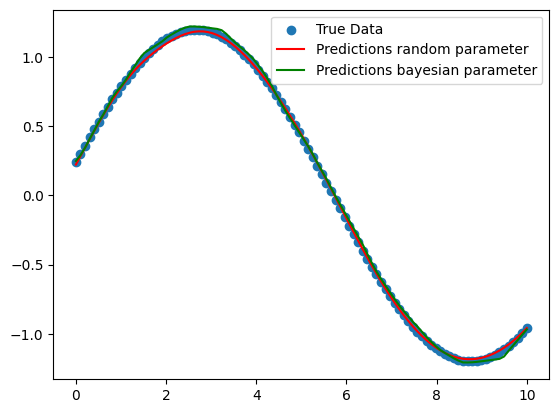

In [17]:
#Look at performance on test data
X = test["X"]

y_pred_rand = model_optimized_rand(X).squeeze(-1)
y_pred_bayes = model_optimized_bayes(X).squeeze(-1)

n = 110 #defines which initial conditions we look at?
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred_rand.cpu().detach()[n], color="red", label="Predictions random parameter")
plt.plot(test["t_tensor"][n], y_pred_bayes.cpu().detach()[n], color="green", label="Predictions bayesian parameter")
plt.legend()
plt.show()

# K-fold 

In [19]:
#put train and validation together so K-fold can do its work
data = {
    'args_tensor': torch.cat([train['args_tensor'], validation['args_tensor']], dim=0),
    'x0_tensor':   torch.cat([train['x0_tensor'],   validation['x0_tensor']],   dim=0),
    't_tensor':    torch.cat([train['t_tensor'],    validation['t_tensor']],    dim=0),
    'y_tensor':    torch.cat([train['y_tensor'],    validation['y_tensor']],    dim=0),
    'X':           torch.cat([train['X'],           validation['X']],           dim=0),
}

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)
fold_losses = []

for train_idx, val_idx in kf.split(data['args_tensor']):
    # Slice each tensor in the dictionary
    train_fold = {k: v[train_idx].to(device) for k, v in data.items()}
    val_fold   = {k: v[val_idx].to(device)   for k, v in data.items()}

    # Initialize model with best hyperparameters
    model = HarmonicModel(n_in=4,
                          hidden_sizes=best_params['hidden_sizes'],
                          activation=best_params['activation']).to(device)

    # Train model on this fold
    train_harmonic(model, lr=best_params['lr'], epochs=100, data=train_fold)
    loss_val = evaluate_harmonic(model, data=val_fold)
    fold_losses.append(loss_val)

average_cv_loss = sum(fold_losses) / K
print("Estimated generalization loss (K-Fold CV):", average_cv_loss)


Epoch 100/100, Loss: 0.0455
Epoch 100/100, Loss: 0.0254
Epoch 100/100, Loss: 0.0436
Epoch 100/100, Loss: 0.0240
Epoch 100/100, Loss: 0.0451
Estimated generalization loss (K-Fold CV): 0.040747028589248654


# Test the model on noisy data

In [21]:
def add_noise_to_dataset(dataset, tensor_keys=['y_tensor'], noise_std=0.05, seed=None):
    """
    Add Gaussian noise to specified tensors in a dataset.

    Args:
        dataset (dict): Dictionary of tensors, e.g., {'y_tensor': ..., 't_tensor': ...}
        tensor_keys (list): Which tensors to add noise to (usually target/output tensors)
        noise_std (float): Standard deviation of Gaussian noise
        seed (int, optional): Random seed for reproducibility
    Returns:
        noisy_dataset (dict): Copy of dataset with added noise
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    noisy_dataset = {k: v.clone() for k, v in dataset.items()}  # copy original tensors
    
    for key in tensor_keys:
        noisy_dataset[key] += torch.randn_like(dataset[key]) * noise_std
    
    return noisy_dataset


In [24]:
#Noisy data (create only 1 set to check the model performances)
train_no_noise, validation_no_noise, test_no_noise = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)

# Example: add noise with std=0.1 to y_tensor
noise_std = 0.5
train_noise = add_noise_to_dataset(train_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
validation_noise = add_noise_to_dataset(validation_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)
test_noise = add_noise_to_dataset(test_no_noise, tensor_keys=['y_tensor'], noise_std=noise_std, seed=0)

# test dataset bayes
X = test_noise["X"]
y_pred_noise = best_model(X).squeeze(-1)


test_loss_bayes_noise = evaluate_harmonic(best_model, data=test_noise)
print(f"Test Loss Random optimization: {test_loss_bayes_noise:.4f}")

Test Loss Random optimization: 0.1970


/tmp/ipykernel_59338/1405275027.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


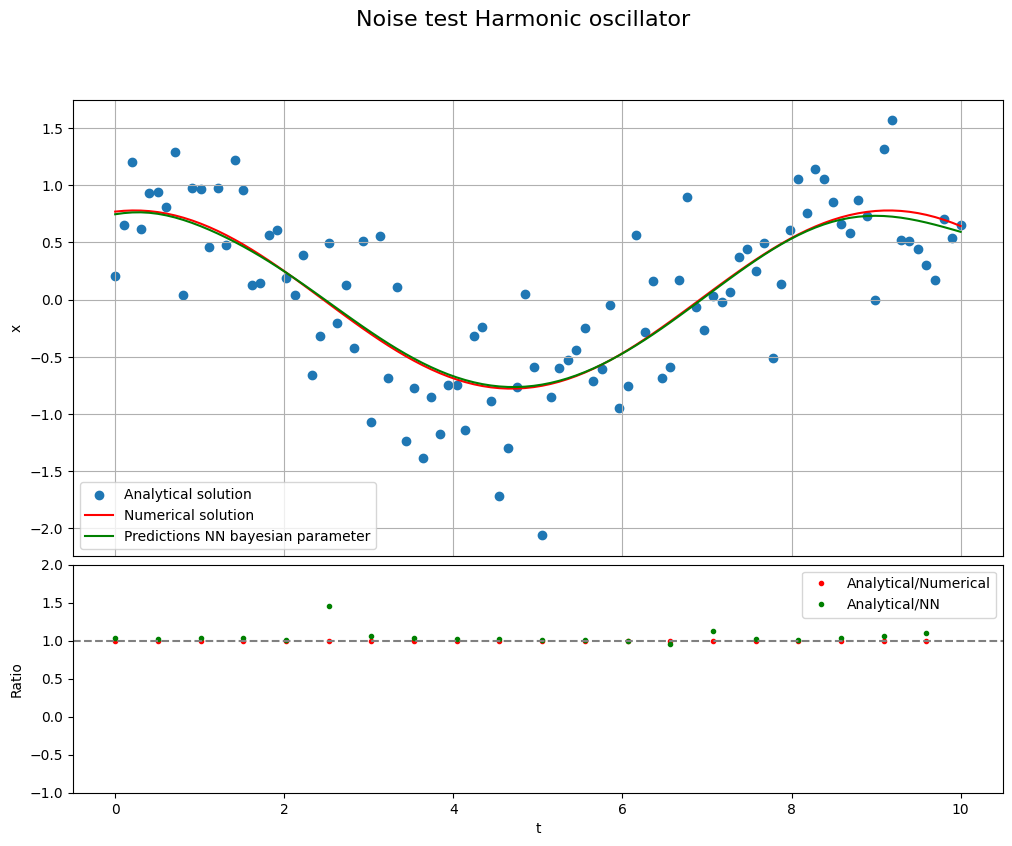

In [25]:
n = 0

y_pred_noise.to("cpu")
test_noise["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_noise["x0_tensor"][n][0], test_noise["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_noise["t_tensor"][n][0], test_noise["t_tensor"][n][-1]
w = test_noise["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_noise["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_no_noise["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_no_noise["y_tensor"][n][0:, 0]/y_pred_noise.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_noise["t_tensor"][n], test_noise["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_noise["t_tensor"][n], y_pred_noise.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_noise["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Noise test Harmonic oscillator", fontsize=16)
plt.show()

# Test generalization

In [26]:
#Generalization
train_generalization, validation_generalization, test_generalization = create_trainig_validation_test_set(harmonic_osc, (0, 50), 100, 1, [0.5, 0.2, 0.3], "RK45", device=device, seed=0)
# test dataset bayes
X = test_generalization["X"]
y_pred_generalization = best_model(X).squeeze(-1)


test_loss_bayes_generalization = evaluate_harmonic(best_model, data=test_generalization)
print(f"Test Loss Random optimization: {test_loss_bayes_generalization:.4f}")

Test Loss Random optimization: 7.5847


/tmp/ipykernel_59338/2674055991.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]


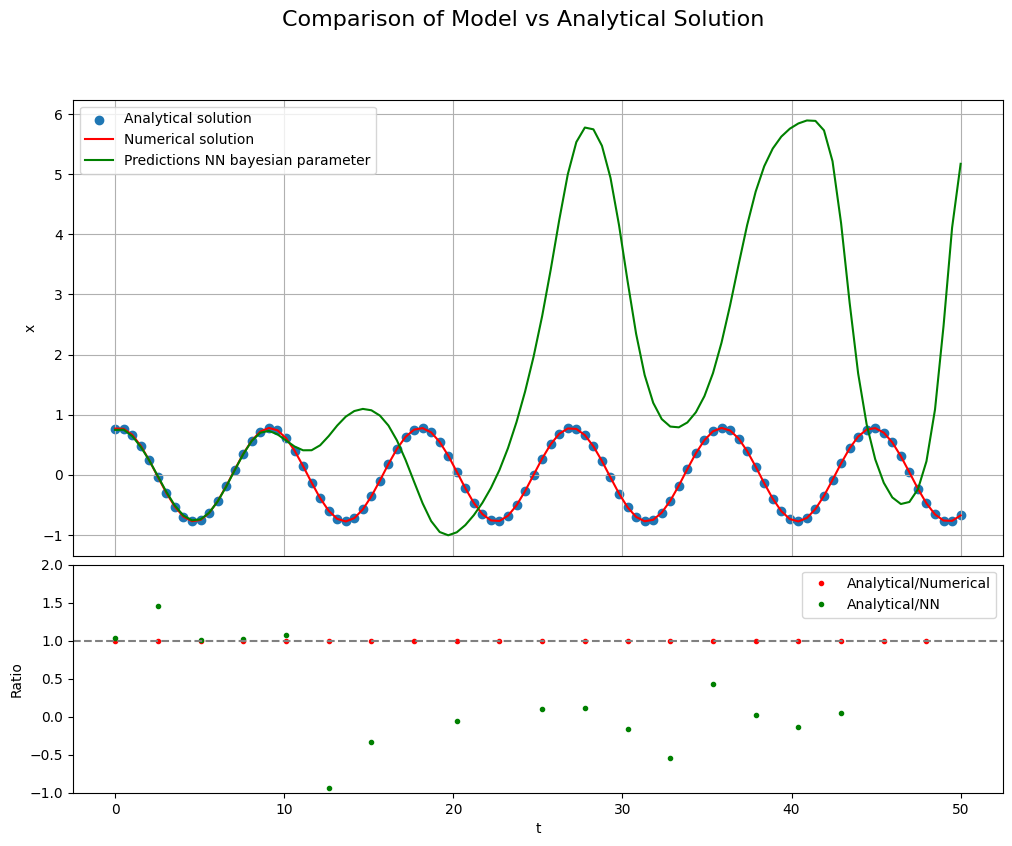

In [28]:
n = 0

y_pred_generalization.to("cpu")
test_generalization["t_tensor"].to("cpu")

#Solve numerically
y0 = [test_generalization["x0_tensor"][n][0], test_generalization["x0_tensor"][n][1]]  # initial condition [x0, v0]
t_span = test_generalization["t_tensor"][n][0], test_generalization["t_tensor"][n][-1]
w = test_generalization["args_tensor"][n]

diff = differential_equation_2_order
sol = sp.integrate.solve_ivp(diff, t_span, y0, t_eval=test_generalization["t_tensor"][n], method='RK45', args=(w))

# Create figure with GridSpec
fig = plt.figure(figsize=(12, 9))
gs = fig.add_gridspec(2, 1, height_ratios=[2, 1], hspace=0.025)

#create ratios for lower plot
slice = 5
ratio_an_num = (test_generalization["y_tensor"][n][0:, 0]/sol.y[0])[::slice]
ratio_an_NN = (test_generalization["y_tensor"][n][0:, 0]/y_pred_generalization.cpu().detach()[n])[::slice]

# Main plot
ax_main = fig.add_subplot(gs[0])
ax_main.scatter(test_generalization["t_tensor"][n], test_generalization["y_tensor"][n][0:, 0], label="Analytical solution") #analytical
ax_main.plot(sol.t, sol.y[0], label='Numerical solution', color = 'red') #numerical
ax_main.plot(test_generalization["t_tensor"][n], y_pred_generalization.cpu().detach()[n], color="green", label="Predictions NN bayesian parameter") #NN ML
ax_main.set_ylabel('x')
ax_main.legend()
ax_main.grid(True)
ax_main.tick_params(bottom=False)  # remove x-axis ticks for main plot

# Ratio / comparison plot
ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_num, '.', label='Analytical/Numerical', color='red')
ax_ratio.plot(test_generalization["t_tensor"][n][::slice], ratio_an_NN, '.', label='Analytical/NN', color='green')
ax_ratio.axhline(1, color='gray', linestyle='--')
ax_ratio.set_xlabel('t')
ax_ratio.set_ylabel('Ratio')
ax_ratio.set_ylim(-1, 2)
ax_ratio.legend()

fig.suptitle("Comparison of Model vs Analytical Solution", fontsize=16)
plt.show()

# Test physical quantities

### Energy conservation

Initial energy E0 = 1.378012e-01
Max absolute deviation = 8.728250e+00
Max relative deviation = 6.333941e+01


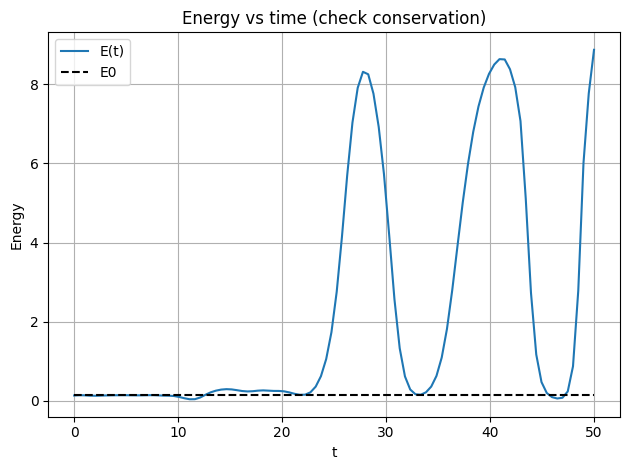

In [29]:
n = 0  # choose trajectory index

# Position
x = y_pred_generalization[n].detach().cpu().numpy()

# Time
t = test_generalization["t_tensor"][n].detach().cpu().numpy()

# Velocity via finite difference
v = np.gradient(x, t)

#Energy conservation (check on generalized data)
E_t = 0.5 * v**2 + 0.5 * float(w) * x**2
E0 = E_t[0]

# diagnostics
abs_dev = np.max(np.abs(E_t - E0))
rel_dev = np.max(np.abs((E_t - E0) / E0))

print(f"Initial energy E0 = {E0:.6e}")
print(f"Max absolute deviation = {abs_dev:.6e}")
print(f"Max relative deviation = {rel_dev:.6e}")

plt.plot(test_generalization["t_tensor"][n], E_t, label='E(t)')
plt.hlines(E0, sol.t[0], sol.t[-1], colors='k', linestyles='dashed', label='E0')
#plt.ylim(0,2)
plt.xlabel('t')
plt.ylabel('Energy')
plt.title('Energy vs time (check conservation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# TO DO

- Test physical quantities of model
- Make sure both models are comparable
- Compare both models